# Characterization of corpus callosum DWI using autoencoder

## Abstract

Corpus Callosum (CC) is a subcortical, white matter structure with great importance in clinical and research studies because its shape and volume are correlated with subject's characteristics and neurodegenerative diseases. CC segmentation is a important step for any medical, clinical or research posterior study. Currently, magnetic resonance imaging (MRI) is the main tool for evaluating brain because it offers the better soft tissue contrast. Particullary, segmentation in MRI difussion modality has great importante given information associated to brain microstruture and fiber composition.

In this work a method for characterization of the CC using a autoencoder (AE) is proposed.

In [1]:
import sys,os, copy, sqlite3, platform, re
main_path = '/home/wilomaku/Repositories/functions/'
paths = [os.path.abspath(main_path), os.path.abspath('{}dtimp'.format(main_path))]
for path in paths:
    if path not in sys.path:
        sys.path.append(path)

import numpy as np
import dtimp as DTI
import scipy as scipy
import scipy.misc as misc 
import nibabel as ni
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import genfromtxt

from sklearn.manifold import TSNE

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, sampler
from torchvision import transforms
%matplotlib inline

print("Python version: ", platform.python_version())
print("Numpy version: ", np.version.version)
print("Scipy version: ", scipy.__version__)
print("Matplotlib version: ", mpl.__version__)
print("Pytorch version: ", torch.__version__)

/home/wilomaku/anaconda3/lib/python3.6/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


Python version:  3.6.3
Numpy version:  1.13.3
Scipy version:  0.19.1
Matplotlib version:  2.1.0
Pytorch version:  0.2.0_4


# Creating dataloader

In [2]:
class MRIDataset_list(Dataset):
    
    def __init__(self, list_dirs, n_slice=-1, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            n_slice (int): Slice number. If -1, mid slice is passed.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.list_dirs = list_dirs
        self.n_slice = n_slice
        self.transform = transform

    def __len__(self):
        return len(self.list_dirs)

    def __getitem__(self, idx):
        base_path = '{}/'.format(self.list_dirs[idx])
        #for v_x in ['V1','V2','V3']:
        for v_x in ['L1','L2','L3']:
            file_DTI = '{}dti_{}.nii.gz'.format(base_path,v_x)
            vol_dti = ni.load(file_DTI).get_data()
            
            if 'V' in v_x: #Eigen-values case
                if 'vol_2d_concat' in locals() or 'vol_2d_concat' in globals():
                    vol_2d_concat = np.concatenate((vol_2d_concat,vol_dti),axis=-1)
                else:
                    vol_2d_concat = vol_dti
            else: #Eigen-vectors case
                if 'vol_2d_concat' in locals() or 'vol_2d_concat' in globals():
                    vol_2d_concat = np.concatenate((vol_2d_concat,np.expand_dims(vol_dti, axis=-1)),axis=-1)
                else:
                    vol_2d_concat = np.expand_dims(vol_dti, axis=-1)

        if self.n_slice == -1:
            slice_ch = int(vol_2d_concat.shape[0]/2)
            vol_2d = vol_2d_concat[slice_ch]
        else:
            vol_2d = vol_2d_concat[self.n_slice]
        
        del(vol_2d_concat)
        if self.transform:
            vol_2d = self.transform(vol_2d)

        return vol_2d
    
class ToTensor(object):
    """Numpy-arrays to Tensors."""
    def __call__(self, sample):
        image = sample.swapaxes(0,-1)
        return torch.Tensor(image).type(torch.FloatTensor)

class ToNormalize(object):
    """Normalization between 0 and 1."""
    def __call__(self, sample):
        return sample/torch.max(sample)
    
class ToCrop(object):
    """Crop image to CC region."""
    def __call__(self, sample):
        return sample[:,10:-10,60:-60]

In [ ]:
input_path = '/home/wilomaku/Documents/study_char/'
base_path = '{}anom/'.format(input_path)
db_anon = '{}mod_preprocess_2.sqlite3'.format(input_path)

anon = sqlite3.connect(db_anon)
anon_cur = anon.cursor()

sql = "SELECT acq_folder FROM anon_modalities INNER JOIN anon_preprocess ON anon_preprocess.id = anon_modalities.id"
anon_cur.execute(sql)
anon_con_cur = anon_cur.fetchall()
dirs_all = np.asarray(anon_con_cur).flatten()
anon_cur.close()
anon.close()

all_folders = [os.path.join(base_path,x) for x in dirs_all]

for l_x in ['L1','L2','L3']:
    base_path = '{}/'.format(all_folders[0])
    file_DTI = '{}dti_{}.nii.gz'.format(base_path,l_x)
    vol_dti = ni.load(file_DTI).get_data()
    
    slice_ch = int(vol_dti.shape[0]/2)
    vol_2d = vol_dti[slice_ch]
    print(vol_2d.shape)
    
    plt.imshow(vol_2d,cmap='gray', origin='lower')
    plt.show()

for v_x in ['V1','V2','V3']:
    base_path = '{}/'.format(all_folders[0])
    file_DTI = '{}dti_{}.nii.gz'.format(base_path,v_x)
    vol_dti = ni.load(file_DTI).get_data()
    print(vol_dti.shape)
    slice_ch = int(vol_dti.shape[0]/2)
    vol_2d = vol_dti[slice_ch]
    print(vol_2d.shape)
    if 'vol_2d_concat' in locals() or 'vol_2d_concat' in globals():
        vol_2d_concat = np.concatenate((vol_2d_concat,vol_2d),axis=-1)
    else:
        vol_2d_concat = vol_2d
    
    for grad_x in np.arange(3):
        plt.imshow(vol_2d[:,:,grad_x],cmap='gray', origin='lower')
        plt.show()
print(vol_2d_concat.shape)

In [3]:
input_path = '/home/wilomaku/Documents/study_char/'
base_path = '{}anom/'.format(input_path)
db_anon = '{}mod_preprocess_2.sqlite3'.format(input_path)

anon = sqlite3.connect(db_anon)
anon_cur = anon.cursor()

sql = "SELECT acq_folder FROM anon_modalities INNER JOIN anon_preprocess ON anon_preprocess.id = anon_modalities.id"
anon_cur.execute(sql)
anon_con_cur = anon_cur.fetchall()
dirs_all = np.asarray(anon_con_cur).flatten()
anon_cur.close()
anon.close()

all_folders = [os.path.join(base_path,x) for x in dirs_all]

grad_ch = 0
n_samples = len(all_folders)

transformed_dataset = MRIDataset_list(list_dirs=all_folders, transform=transforms.Compose([ToTensor(), ToNormalize(),
                                                                                           ToCrop()]))
indices = np.array(range(n_samples))
Cin = transformed_dataset[0].numpy().shape[0] #Input Channels

New dataset size (Leaving out sized-different subjects):  202
1 torch.Size([3, 50, 136]) 1.0
2 torch.Size([3, 50, 136]) 0.9390245079994202
3 torch.Size([3, 50, 136]) 1.0
4 torch.Size([3, 50, 136]) 0.9058942794799805
5 torch.Size([3, 50, 136]) 0.9595085382461548
6 torch.Size([3, 50, 136]) 1.0
7 torch.Size([3, 50, 136]) 1.0
8 torch.Size([3, 50, 136]) 1.0
9 torch.Size([3, 50, 136]) 1.0


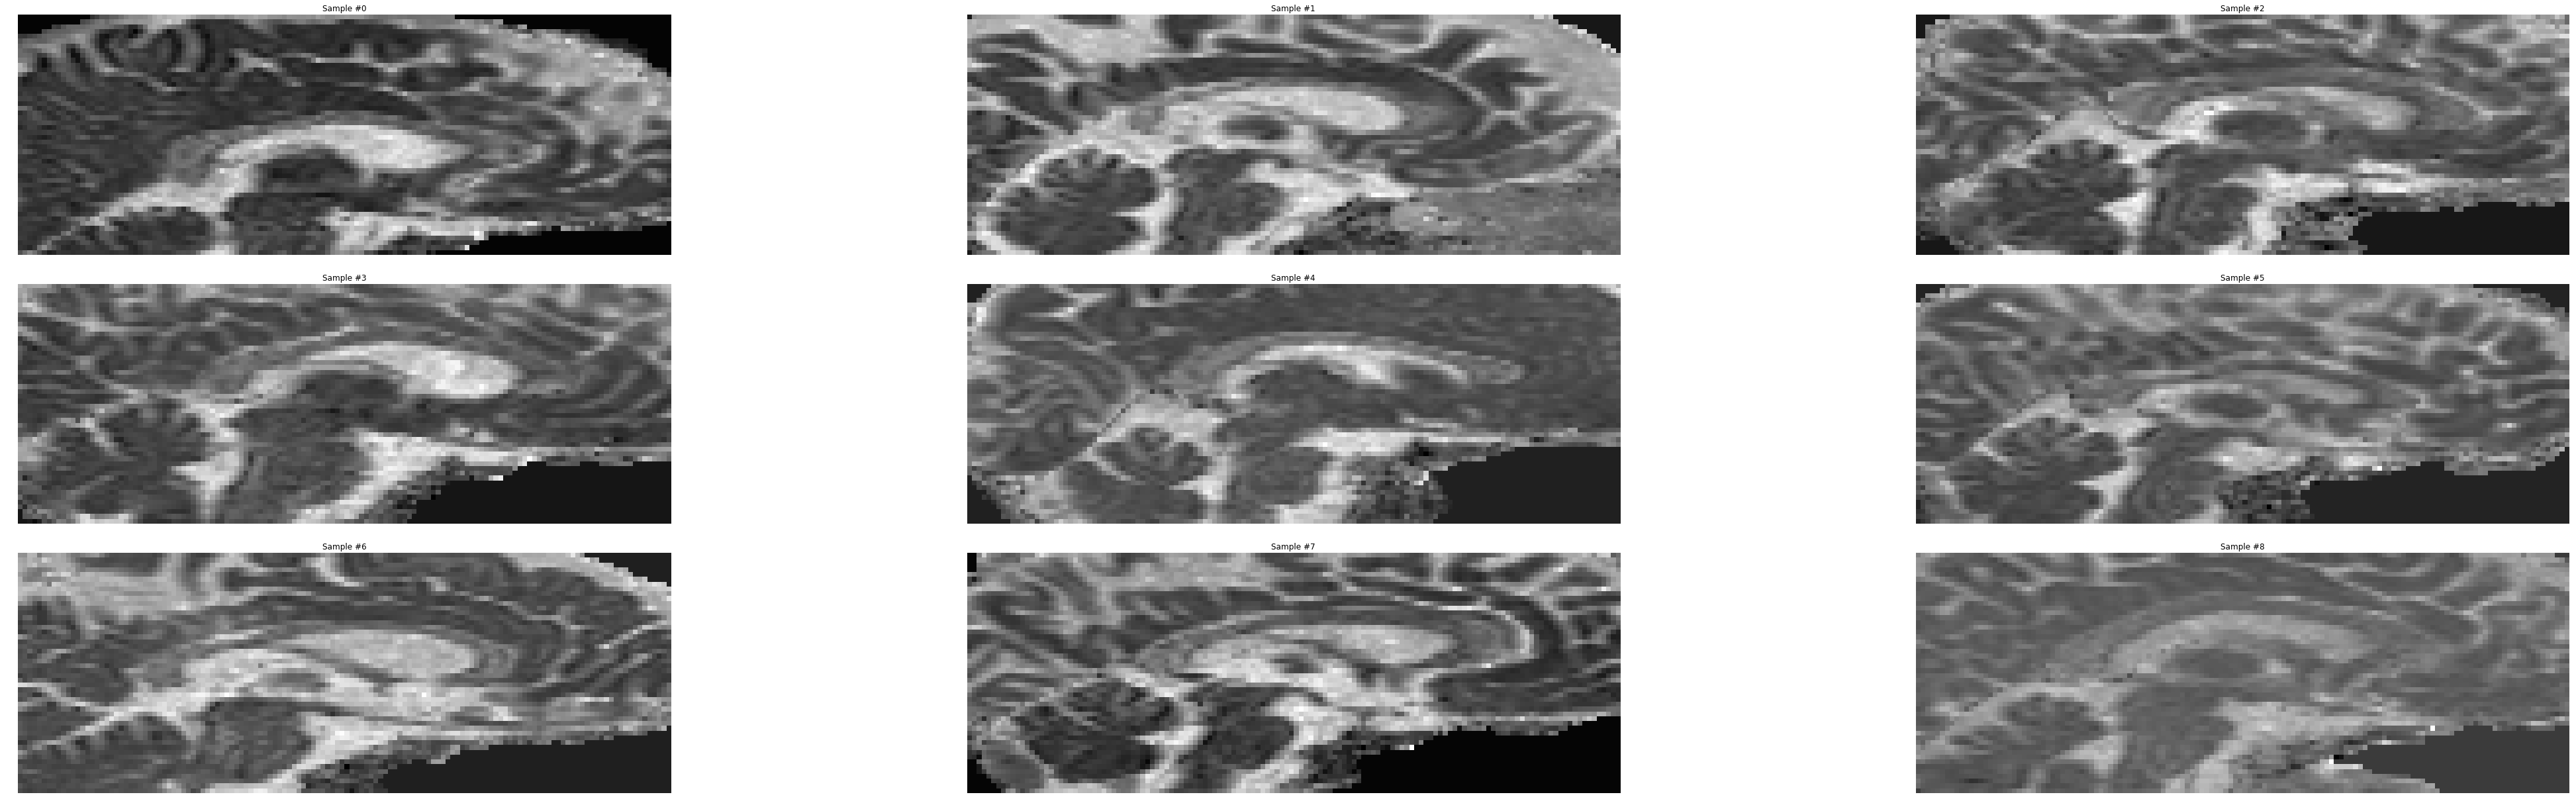

In [4]:
fig = plt.figure(figsize=(60,62))
print('New dataset size (Leaving out sized-different subjects): ', n_samples)
for i in indices:
    sample = transformed_dataset[i]
    print(i+1,sample.size(),torch.max(sample))
    ax = plt.subplot(11, 3, i+1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample.numpy()[grad_ch],cmap='gray', origin='lower')
    if i == 8:
        plt.show()
        break
plt.show()

In [5]:
split = 42 #Number of elements in test set
test_idx = np.random.choice(np.array(indices), size=split, replace=False)
train_idx = list(set(indices) - set(test_idx))

train_sampler = sampler.SubsetRandomSampler(train_idx)
test_sampler = sampler.SubsetRandomSampler(test_idx)

train_loader = DataLoader(transformed_dataset, batch_size=split, shuffle=False, sampler=train_sampler)
test_loader = DataLoader(transformed_dataset, batch_size=split, shuffle=False, sampler=test_sampler)
print('====== Train Dataloader ======')
for i_batch, sample_batched in enumerate(train_loader):
    print(i_batch, sample_batched.size())
print('====== Test Dataloader ======')
for i_batch, sample_batched in enumerate(test_loader):
    print(i_batch, sample_batched.size())

====== Train Dataloader ======
0 torch.Size([42, 3, 50, 136])
1 torch.Size([42, 3, 50, 136])
2 torch.Size([42, 3, 50, 136])
3 torch.Size([34, 3, 50, 136])
====== Test Dataloader ======
0 torch.Size([42, 3, 50, 136])


# Autoencoder

In [6]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.conv1 = nn.Conv2d(Cin, 4, kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.mpool1 = nn.MaxPool2d(kernel_size=2, stride=1, return_indices=True)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=1)
        self.mpool2 = nn.MaxPool2d(kernel_size=2, stride=1, return_indices=True)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1)
        self.mpool3 = nn.MaxPool2d(kernel_size=2, stride=1, return_indices=True)
        self.conv4 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
        self.mpool4 = nn.MaxPool2d(kernel_size=2, stride=1, return_indices=True)
        #self.fc_c5 = nn.Linear(32*2*7,3)
        # == Decodification ==
        #self.fc_d5 = nn.Linear(3,32*2*7)
        self.deconv4 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=(0,1))
        self.mupool4 = nn.MaxUnpool2d(kernel_size=2, stride=1)
        self.deconv3 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1)
        self.mupool3 = nn.MaxUnpool2d(kernel_size=2, stride=1)
        self.deconv2 = nn.ConvTranspose2d(8, 4, kernel_size=3, stride=2, padding=1, output_padding=(1,0))
        self.mupool2 = nn.MaxUnpool2d(kernel_size=2, stride=1)
        self.deconv1 = nn.ConvTranspose2d(4, Cin, kernel_size=3, stride=2, padding=1, output_padding=(1,1))
        self.mupool1 = nn.MaxUnpool2d(kernel_size=2, stride=1)

    def encode(self, x):
        h1, self.ind1 = self.mpool1(self.relu(self.conv1(x)))
        h2, self.ind2 = self.mpool2(self.relu(self.conv2(h1)))
        h3, self.ind3 = self.mpool3(self.relu(self.conv3(h2)))
        h4, self.ind4 = self.mpool4(self.relu(self.conv4(h3)))
        return h4

    def decode(self, y):
        #i5 = self.fc_d5(y)
        i4 = self.relu(self.deconv4(self.mupool4(y, self.ind4)))
        i3 = self.relu(self.deconv3(self.mupool3(i4, self.ind3)))
        i2 = self.relu(self.deconv2(self.mupool2(i3, self.ind2)))
        return self.relu(self.deconv1(self.mupool1(i2, self.ind1)))

    def forward(self, x):
        y = self.encode(x)
        return self.decode(y), y

In [7]:
net = autoencoder()
print(net)

autoencoder (
  (conv1): Conv2d(3, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (relu): ReLU ()
  (mpool1): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (conv2): Conv2d(4, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (mpool2): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (conv3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (mpool3): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (conv4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (mpool4): MaxPool2d (size=(2, 2), stride=(1, 1), dilation=(1, 1))
  (deconv4): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(0, 1))
  (mupool4): MaxUnpool2d (size=(2, 2), stride=(1, 1), padding=(0, 0))
  (deconv3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (mupool3): MaxUnpool2d (size=(2, 2), stride=(1, 1), padding=(0, 0))
  (deconv2): ConvTranspose2d(8, 4, kernel_size=(3, 3), 

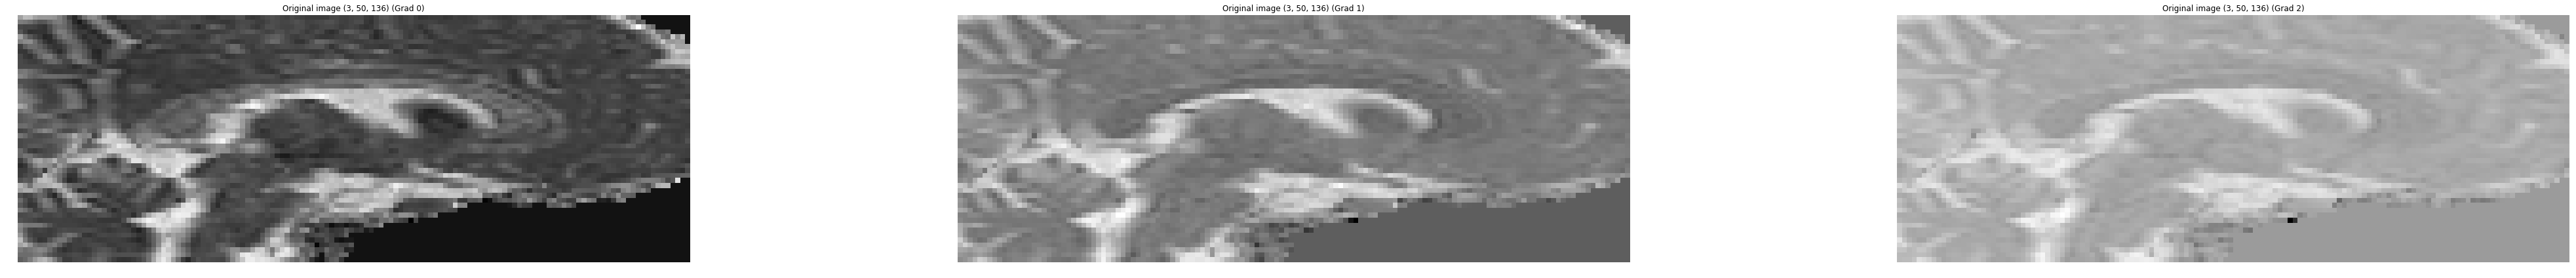

Decod >  torch.Size([42, 3, 50, 136]) Encod >  torch.Size([42, 32, 2, 7])


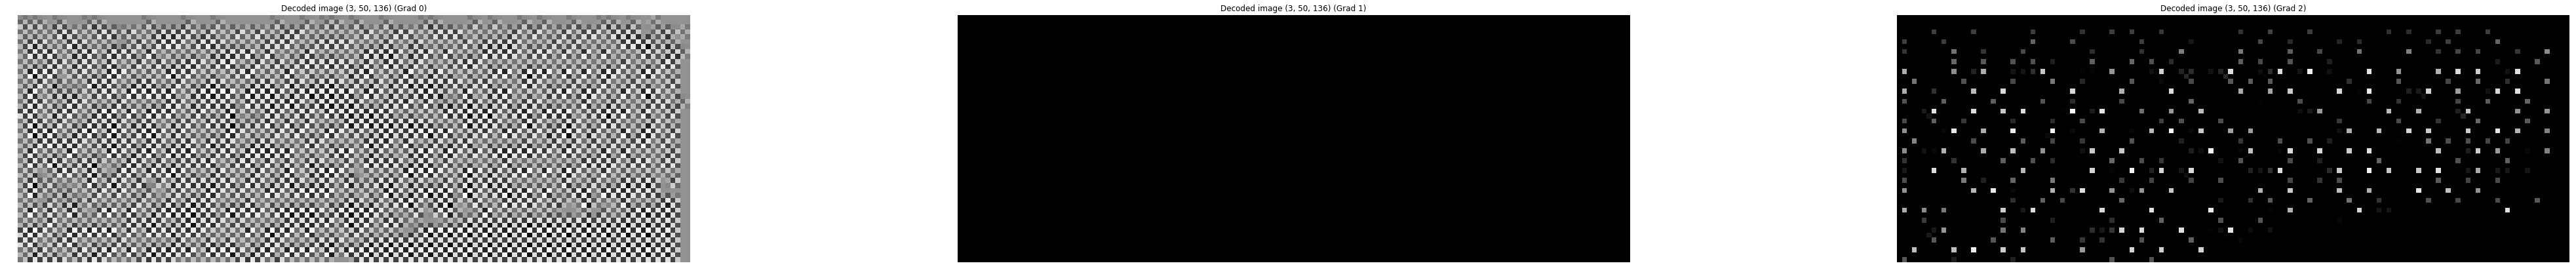

In [8]:
grad_ch = 15

for n_i, sample_batched in enumerate(test_loader):
    or_out = sample_batched.numpy()[0]
    fig = plt.figure(figsize=(60,62))
    for grad in range(Cin):
        ax = plt.subplot(11, 3, grad+1)
        ax.set_title('Original image {} (Grad {})'.format(or_out.shape,grad))
        ax.axis('off')
        plt.tight_layout()
        plt.imshow(or_out[grad],cmap='gray', origin='lower')
    plt.show()
    #######################################################
    dec_out, enc_out = net(Variable(sample_batched))
    print('Decod > ', dec_out.size(), 'Encod > ', enc_out.size())
    pred_out = dec_out.data.numpy()[0]
    fig = plt.figure(figsize=(60,62))
    for grad in range(Cin):
        ax = plt.subplot(11, 3, grad+1)
        ax.set_title('Decoded image {} (Grad {})'.format(pred_out.shape,grad))
        ax.axis('off')
        plt.tight_layout()
        plt.imshow(pred_out[grad],cmap='gray', origin='lower')
    plt.show()
    if n_i == 1:
        break

# Training autoencoder

In [9]:
def train(model,train_loader,valid_loader,loss_fn,optimizer,epochs=10,num_break=5,patience=5,criteria_stop="loss"):
    hist_train_loss = hist_val_loss = hist_train_acc = hist_val_acc = np.array([])
    best_epoch = patience_count = 0

    print("Training starts along %i epoch"%epochs)
    for e in range(epochs):
        correct_train = correct_val = total_train = total_val = 0
        cont_i = loss_t_e = loss_v_e = 0
        for data_train, data_valid in zip(train_loader, valid_loader):
            #if cont_i == num_break:
            #    break

            inputs = data_train
            var_inputs = Variable(inputs)

            predict, encode = model(var_inputs)
            loss = loss_fn(predict, var_inputs)
            loss_t_e += loss.data[0]
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            ##Validating model
            inputs = data_valid
            var_inputs = Variable(inputs)
            predict, encode = model(var_inputs)
            loss_val = loss_fn(predict, var_inputs)
            loss_v_e += loss_val.data[0]

            cont_i += 1

        #Stacking historical
        hist_train_loss = np.hstack((hist_train_loss, loss_t_e/(cont_i*1.0)))
        hist_val_loss = np.hstack((hist_val_loss, loss_v_e/(cont_i*1.0)))
        #if e%10 == 0:
        print('Epoch: ', e, 'train loss: ', hist_train_loss[-1], 'valid loss: ', hist_val_loss[-1])

        #Early stopping by best accuracy or best loss
        if(criteria_stop == "acc"):
            if(hist_val_acc[best_epoch] < hist_val_acc[-1]):
                patience_count = 0
                best_epoch = e
                best_model = copy.copy(model)
        else:
            if(hist_val_loss[best_epoch] > hist_val_loss[-1]):
                patience_count = 0
                best_epoch = e
                best_model = copy.copy(model)

        if(patience_count > patience):
            print("Early stopped")
            break;

        if(e == epochs-1):
            print("Training stopped")
        patience_count += 1

    return(best_model, hist_train_loss, hist_val_loss)

In [10]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())#, lr=0.00001
epochs = 200
patience = 10
max_batch = 42
criteria = "loss"

best_model, loss, loss_test = train(net, train_loader, test_loader, loss_fn, optimizer, epochs = epochs, 
                                     num_break = max_batch, patience = patience, criteria_stop = criteria)

Training starts along 200 epoch
Epoch:  0 train loss:  0.0740540027618 valid loss:  0.0642726942897
Epoch:  1 train loss:  0.0782427191734 valid loss:  0.0641392469406
Epoch:  2 train loss:  0.0716414153576 valid loss:  0.0639988929033
Epoch:  3 train loss:  0.0739186257124 valid loss:  0.0638473778963
Epoch:  4 train loss:  0.077241808176 valid loss:  0.0636891573668
Epoch:  5 train loss:  0.072619907558 valid loss:  0.0635234490037
Epoch:  6 train loss:  0.067678719759 valid loss:  0.0633496046066
Epoch:  7 train loss:  0.0744981095195 valid loss:  0.0631782561541
Epoch:  8 train loss:  0.0715910196304 valid loss:  0.0629937797785
Epoch:  9 train loss:  0.0689119547606 valid loss:  0.0628025233746
Epoch:  10 train loss:  0.0729273110628 valid loss:  0.0625895708799
Epoch:  11 train loss:  0.067773103714 valid loss:  0.0623767860234
Epoch:  12 train loss:  0.0758047923446 valid loss:  0.0621562711895
Epoch:  13 train loss:  0.0712071955204 valid loss:  0.0619380250573
Epoch:  14 train

Epoch:  119 train loss:  0.0340484045446 valid loss:  0.0304539240897
Epoch:  120 train loss:  0.0352663993835 valid loss:  0.0303527601063
Epoch:  121 train loss:  0.0331581383944 valid loss:  0.0300675407052
Epoch:  122 train loss:  0.0356360375881 valid loss:  0.0298822112381
Epoch:  123 train loss:  0.0322252251208 valid loss:  0.0295767020434
Epoch:  124 train loss:  0.033226352185 valid loss:  0.0294108279049
Epoch:  125 train loss:  0.0338106267154 valid loss:  0.0292366314679
Epoch:  126 train loss:  0.0311598777771 valid loss:  0.0291024670005
Epoch:  127 train loss:  0.0323550216854 valid loss:  0.0290049482137
Epoch:  128 train loss:  0.0341639257967 valid loss:  0.0290740896016
Epoch:  129 train loss:  0.0324476584792 valid loss:  0.0288335625082
Epoch:  130 train loss:  0.0318206511438 valid loss:  0.0287000611424
Epoch:  131 train loss:  0.0345975570381 valid loss:  0.0287235863507
Epoch:  132 train loss:  0.0353842973709 valid loss:  0.0287730786949
Epoch:  133 train los

# Testing model

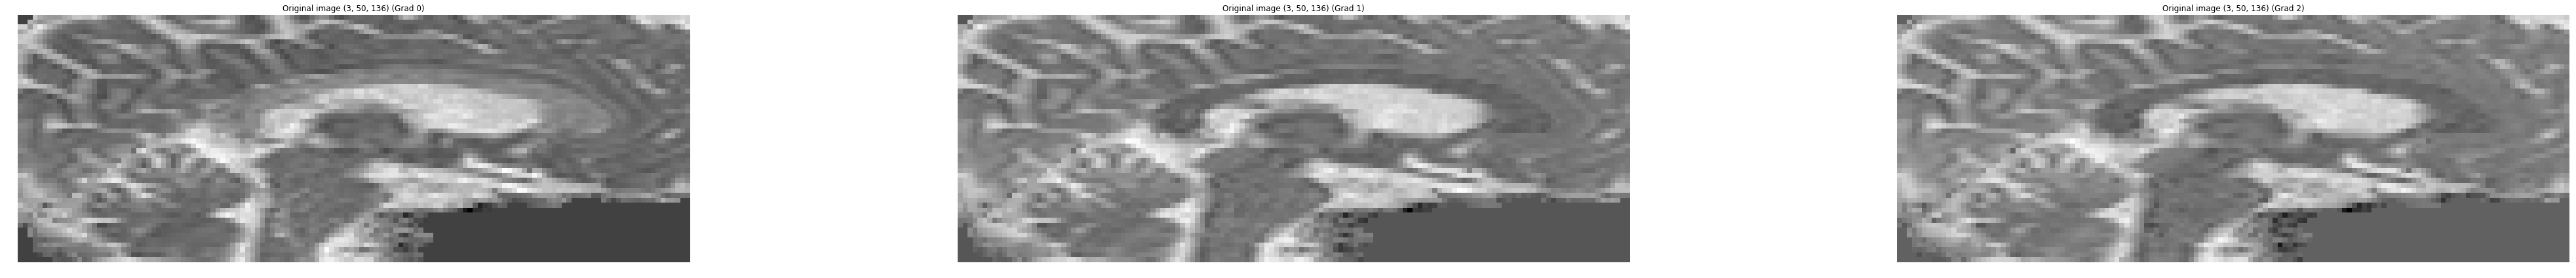

Decod >  torch.Size([42, 3, 50, 136]) Encod >  torch.Size([42, 32, 2, 7])


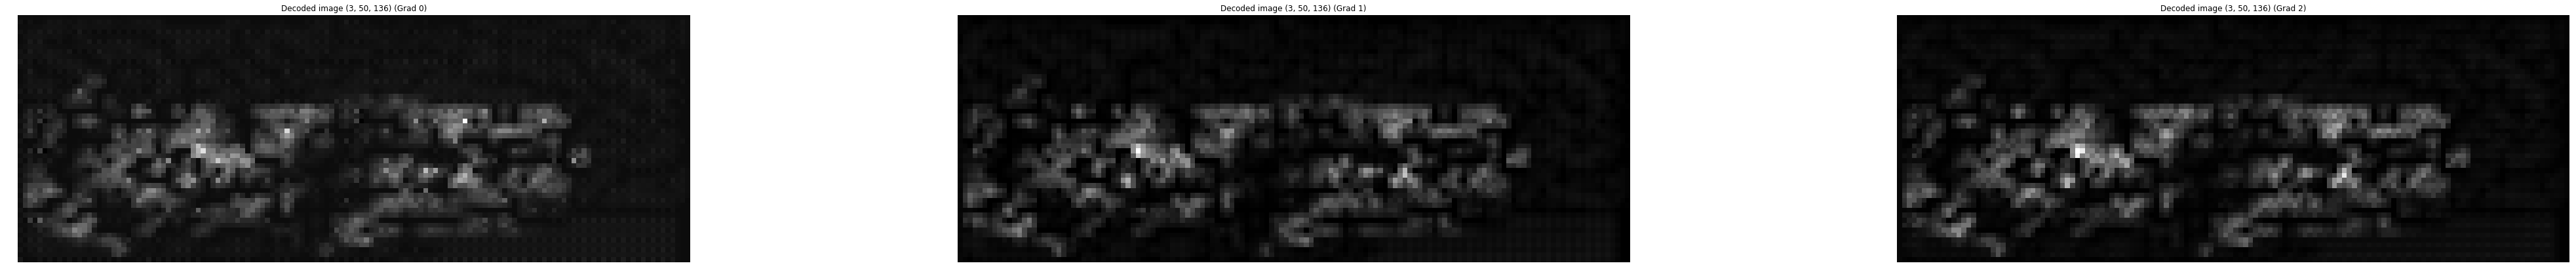

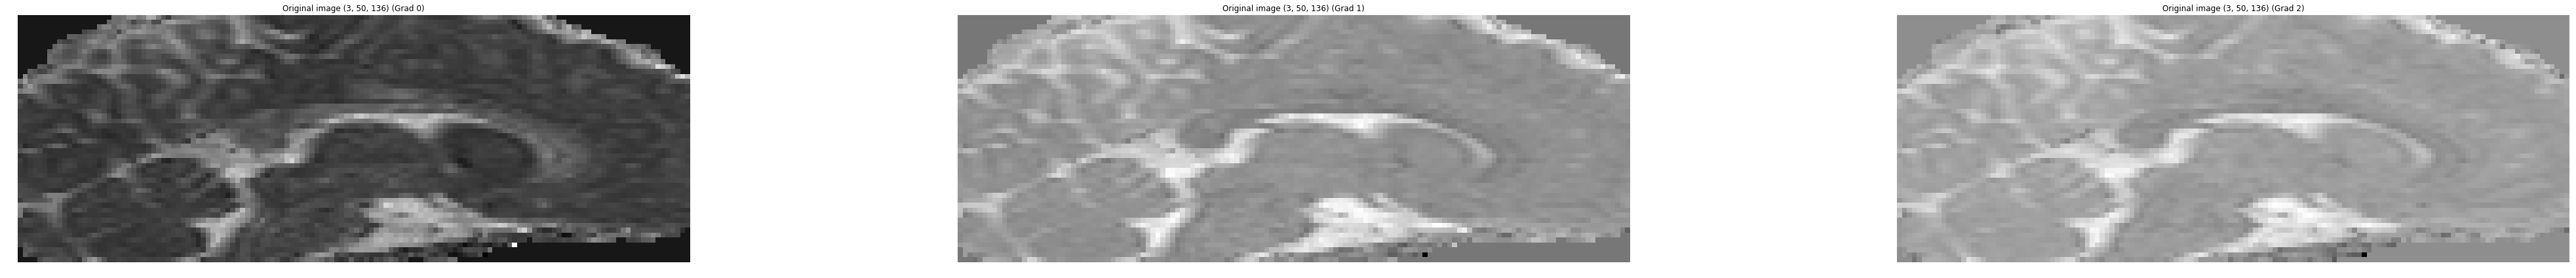

Decod >  torch.Size([42, 3, 50, 136]) Encod >  torch.Size([42, 32, 2, 7])


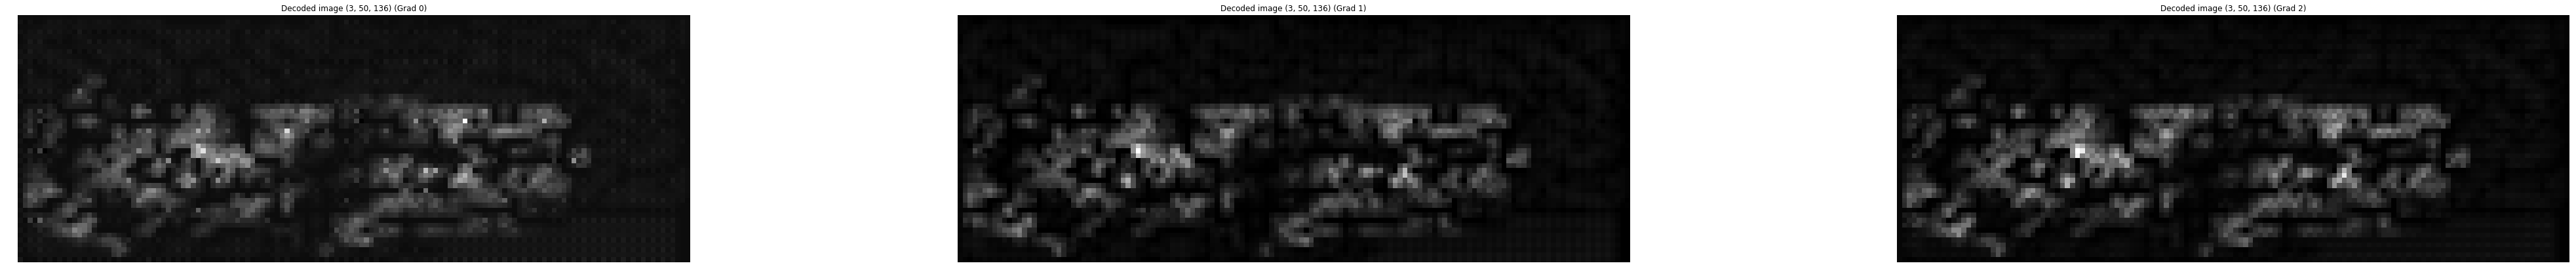

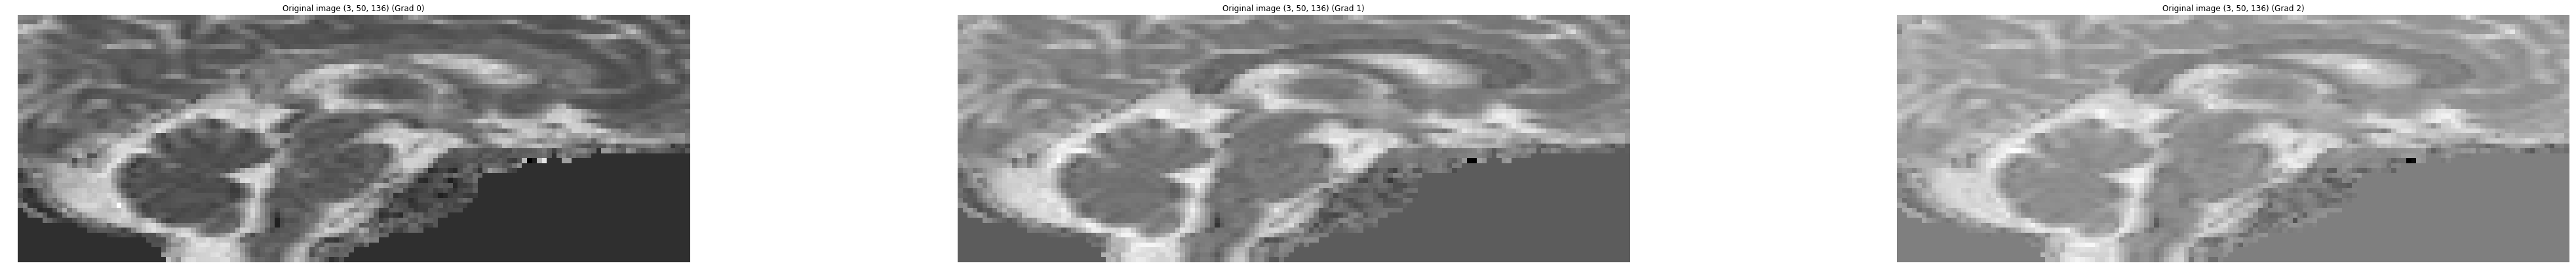

Decod >  torch.Size([42, 3, 50, 136]) Encod >  torch.Size([42, 32, 2, 7])


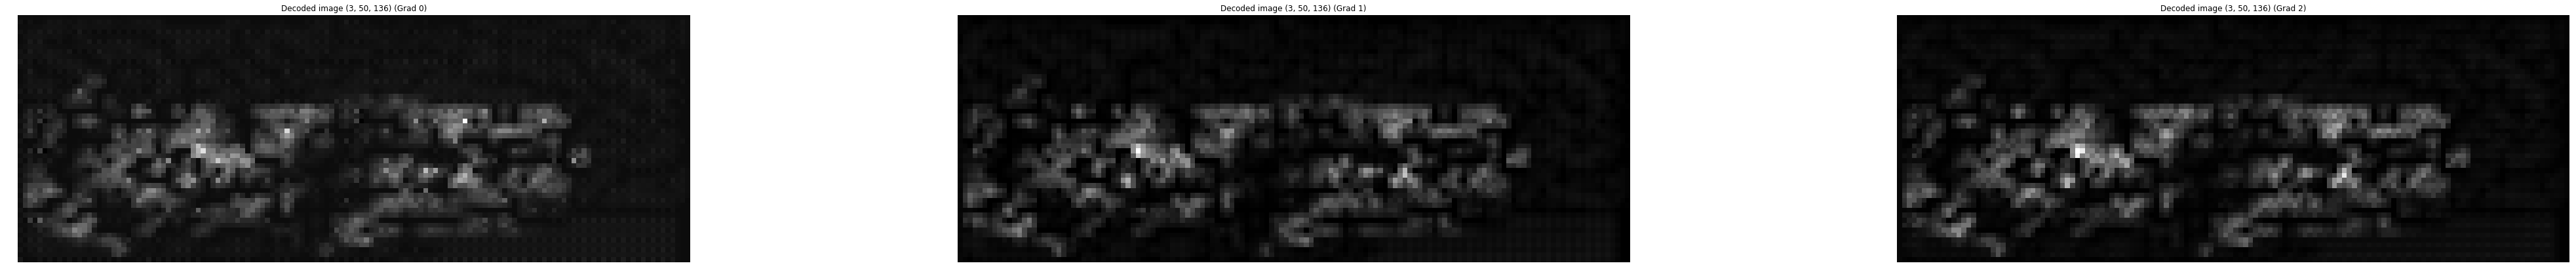

In [11]:
for n_i, sample_batched in enumerate(test_loader):
    n_imag = 3
    for n_i in range(n_imag):
        or_out = sample_batched.numpy()[n_i]
        fig = plt.figure(figsize=(60,62))
        for grad in range(Cin):
            ax = plt.subplot(11, 3, grad+1)
            ax.set_title('Original image {} (Grad {})'.format(or_out.shape,grad))
            ax.axis('off')
            plt.tight_layout()
            plt.imshow(or_out[grad],cmap='gray', origin='lower')
        plt.show()
        #######################################################
        dec_out, enc_out = best_model(Variable(sample_batched))
        print('Decod > ', dec_out.size(), 'Encod > ', enc_out.size())
        pred_out = dec_out.data.numpy()[0]
        fig = plt.figure(figsize=(60,62))
        for grad in range(Cin):
            ax = plt.subplot(11, 3, grad+1)
            ax.set_title('Decoded image {} (Grad {})'.format(pred_out.shape,grad))
            ax.axis('off')
            plt.tight_layout()
            plt.imshow(pred_out[grad],cmap='gray', origin='lower')
        plt.show()
        if n_i == 3:
            break

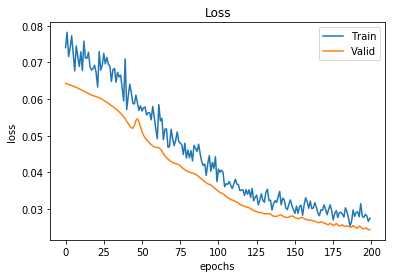

In [12]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(loss, label='Train')
plt.plot(loss_test, label='Valid')
plt.legend()
plt.show()

In [13]:
test_loader_all = next(iter(DataLoader(transformed_dataset, batch_size=n_samples)))

__, enc_out = best_model(Variable(test_loader_all))
print('Encod > ', enc_out.size())

Encod >  torch.Size([202, 32, 2, 7])
